# CNN2a SETTINGS

SUBJECT'S DATA SELECTION:                                                                                                  
- **A**: Signal samples: 7794, EEG channels: 64, Testset letters: 100                                                           
- **B**: Signal samples: 7794, EEG channels: 64, Testset letters: 100 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np     
import random           
from scipy.io import loadmat
from scipy import signal
import warnings
import string
import os

from keras.layers import *
from keras.models import Model
from tensorflow.keras import backend as K
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler


import mne




contributor_selected = "II"                                 
MODEL_LOCATIONS_FILE_PATH = '../model/CNN1/' + contributor_selected
contributor_train_file_path = '../data/Contributor_' + contributor_selected + '_Train.mat'
contributor_test_file_path = '../data/Contributor_' + contributor_selected + '_Test.mat'
channel_name_file_path = '../data/channels.csv'
warnings.filterwarnings('ignore')

# Channel selection
channels = [10, 33, 48, 50, 52, 55, 59, 61]            

# Training set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signals from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 8)**;
6.   Obtain **(noP300 / P300)** class ratio to balance out dataset during training;









In [23]:
from scipy.io import loadmat
from scipy import signal
from bundle.DataCraft import * 

data_train = loadmat(contributor_train_file_path)


# Take only the 8 selected channels of the singal [Fz, Cz, Pz, P3, P4, Po7, Po8, Oz]
signals_train = data_train['Signal']
signals_train = signals_train[:, :, channels]
flashing_train = data_train['Flashing']
stimulus_train = data_train['StimulusType']
word_train = data_train['TargetChar']
sampling_frequency = 240
repetitions = 15
recording_duration_train = (len(signals_train)) * (len(signals_train[0])) / (sampling_frequency * 60)
trials_train = len(word_train[0])

print("Train Data:")
print_data(signals_train,word_train, contributor_selected, sampling_frequency)

Train Data:
Contributor     Sampling Freq. (Hz)  Recording (min)      Trials     Spelled Word                  
II              240.00               46.01                85         VGREAAH8TVRHBYN_UGCOLO4EUERDOO
                                                                     HCIFOMDNU6LQCPKEIREKOYRQIDJXPB
                                                                     KOJDWZEUEWWFOEBHXTQTTZUMO     


In [5]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1 / sampling_frequency, 20 / sampling_frequency], 'bandpass')
for trial in range(trials_train):
    signals_train[trial, :, :] = signal.filtfilt(b, a, signals_train[trial, :, :], axis=0)
    
    # Down-sampling of the signals from 240Hz to 120Hz
down_sampling_frequency = 120
SCALE_FACTOR = round(sampling_frequency / down_sampling_frequency)
sampling_frequency = down_sampling_frequency

print("# Samples of EEG signals before downsampling: {}".format(len(signals_train[0])))

signals_train = signals_train[:, 0:-1:SCALE_FACTOR, :]
flashing_train = flashing_train[:, 0:-1:SCALE_FACTOR]
stimulus_train = stimulus_train[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_train[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [7]:
# Number of EEG channels
N_CHANNELS = len(channels)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(sampling_frequency * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL = len(signals_train[0])

train_features = []
train_labels = []

count_positive = 0
count_negative = 0

for trial in range(trials_train):
    for sample in (range(SAMPLES_PER_TRIAL)):
        if (sample == 0) or (flashing_train[trial, sample - 1] == 0 and flashing_train[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_train[trial, lower_sample:upper_sample, :]                
            # Features extraction
            train_features.append(window)
            # Labels extraction
            if stimulus_train[trial, sample] == 1:
                count_positive += 1
                train_labels.append(1) # Class P300
            else:
                count_negative += 1
                train_labels.append(0) # Class no-P300

# Get negative-positive classes ratio
train_ratio = count_negative/count_positive

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# 3D Tensor shape (SAMPLES, 78, 8)
dim_train = train_features.shape
print("Features tensor shape: {}".format(dim_train))

Features tensor shape: (15300, 78, 8)


In [8]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(train_features)):
    train_features[pattern] = scale(train_features[pattern], axis=0)

# Testing set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signas from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 8)**;
6.   Calculate weights vector to balance samples importance and obtain correct accuracy estimation;

In [9]:
# Test data loading
if not os.path.exists(contributor_test_file_path):
    print("Missing file: {}", contributor_test_file_path)
else:
    # Load the required data
    data_test = loadmat(contributor_test_file_path)
    # Get the variables of interest from the loaded dictionary
    signals_test = data_test['Signal']
    signals_test = signals_test[:, :, channels]
    flashing_test = data_test['Flashing']
    word_test =  data_test['TargetChar']
    stimulus_code_test = data_test['StimulusCode']

    sampling_frequency = 240
    # From the dataset description we know that there are 15 repetitions
    repetitions = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION_TEST = (len(signals_test))*(len(signals_test[0]))/(sampling_frequency * 60)
    # Compute number of trials
    TRIALS_TEST = len(word_test[0])
    # Number of samples for each character in trials
    SAMPLES_PER_TRIAL_TEST = len(signals_test[0])
    
    print("**********************************")
    print("        TEST SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (sampling_frequency, (1000 / sampling_frequency)))
    print("Session duration:   %.2f min" % RECORDING_DURATION_TEST)
    print("Number of letters:  %d" % TRIALS_TEST)
    print("Spelled word:       %s" % ''.join(word_test))

**********************************
        TEST SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   54.12 min
Number of letters:  100
Spelled word:       MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR


In [10]:
# Create characters matrix
char_matrix = [[0 for j in range(6)] for i in range(6)]
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]
    list_matrix.append(row)

# Create StimulusType array for the test set (missing from the given database)
stimulus_test = [[0 for j in range(SAMPLES_PER_TRIAL_TEST)] for i in range(TRIALS_TEST)]
stimulus_test = np.array(stimulus_test)

for trial in range(TRIALS_TEST):
    counter=0
    for sample in range(SAMPLES_PER_TRIAL_TEST):
        index = int(stimulus_code_test[trial, sample]) - 1
        if not index == -1:
            if word_test[0][trial] in list_matrix[index]:
                stimulus_test[trial, sample] = 1
            else:
                stimulus_test[trial, sample] = 0

In [11]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1 / sampling_frequency, 20 / sampling_frequency], 'bandpass')
for trial in range(TRIALS_TEST):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)

In [12]:
# Down-sampling of the signals from 240Hz to 120Hz
down_sampling_frequency = 120
SCALE_FACTOR = round(sampling_frequency / down_sampling_frequency)
sampling_frequency = down_sampling_frequency

print("# Samples of EEG signals before downsampling: {}".format(len(signals_test[0])))

signals_test = signals_test[:, 0:-1:SCALE_FACTOR, :]
flashing_test = flashing_test[:, 0:-1:SCALE_FACTOR]
stimulus_test = stimulus_test[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_test[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [13]:
# Number of EEG channels
N_CHANNELS = len(channels)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(sampling_frequency * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL_TEST = len(signals_train[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS_TEST):
    for sample in (range(SAMPLES_PER_TRIAL_TEST)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes 
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 78, 64)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

Features tensor shape: (18000, 78, 8)


In [14]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

# CNN2a model definition, training and testing

1.   Function definiton for randomization of weights and biases;
2.   **Scaled_tanh(x)** activation function definition;
3.   ANN model definition (2 Conv1D layers, 2 dense layers);
4.   Training of the network over weighted datasets;
5.   CNN2a performance assessment;

In [15]:
# Randomizing function for bias and weights of the network
def cecotti_normal(shape, dtype = None, partition_info = None):
    if len(shape) == 1:
        fan_in = shape[0]
    elif len(shape) == 2:
        fan_in = shape[0]
    else:
        receptive_field_size = 1
        for dim in shape[:-2]:
            receptive_field_size *= dim
        fan_in = shape[-2] * receptive_field_size
    return K.random_normal(shape, mean = 0.0, stddev = (1.0 / fan_in))

In [16]:
# Custom tanh activation function
def scaled_tanh(z):
    return 1.7159 * K.tanh((2.0 / 3.0) * z)

In [17]:
# Build the model
def CNN2a_model(channels=8, filters=10):
    model = Sequential([
        Conv1D(
            filters = filters,
            kernel_size = 1,
            padding = "same",
            bias_initializer = cecotti_normal,
            kernel_initializer = cecotti_normal,
            use_bias = True,
            activation = scaled_tanh,
            input_shape = (78, channels)
        ),
        Conv1D(
            filters = 50,
            kernel_size = 13,
            padding = "valid",
            strides = 11,
            bias_initializer = cecotti_normal,
            kernel_initializer = cecotti_normal,
            use_bias = True,
            activation = scaled_tanh,
        ),
        Flatten(),
        Dense(100, activation="sigmoid"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    return model

In [18]:
# Training parameters
BATCH_SIZE = 256
EPOCHS = 200
VALID_SPLIT = 0.05
SHUFFLE = 1 # set to 1 to shuffle subsets during training

# Model summary
CNN2a_model(channels=8, filters=10).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 78, 10)         │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 50)          │         6,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,841 (143.91 KB)

 Trainable params: 36,841 (143.91 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Model definition
model = CNN2a_model(channels=8, filters=10)

# Callback to save best model only
checkpoint = ModelCheckpoint(filepath=MODEL_LOCATIONS_FILE_PATH + "/" + "model" + ".keras", 
                             monitor='val_loss', 
                             mode='min',
                             save_best_only=True)

# Callback to stop when loss on validation set doesn't decrease in 50 epochs
earlystop = EarlyStopping(monitor = 'val_loss', 
                              mode = 'min', 
                              patience = 50, 
                              restore_best_weights = True)

# Callback to keep track of model statistics
history = model.fit(x=train_features, 
                    y=train_labels, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_split=VALID_SPLIT, 
                    callbacks=[checkpoint, earlystop],
                    shuffle=SHUFFLE,
                    class_weight={0: 1., 1: train_ratio})

Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5560 - loss: 0.3891 - val_accuracy: 0.7163 - val_loss: 0.1928
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7193 - loss: 0.3173 - val_accuracy: 0.7804 - val_loss: 0.1581
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7502 - loss: 0.2964 - val_accuracy: 0.7739 - val_loss: 0.1560
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7406 - loss: 0.2995 - val_accuracy: 0.7464 - val_loss: 0.1735
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7378 - loss: 0.3002 - val_accuracy: 0.7647 - val_loss: 0.1595
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7499 - loss: 0.2867 - val_accuracy: 0.7281 - val_loss: 0.1810
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7480 - loss: 0.2906 - val_accuracy: 0.7634 - val_loss: 0.1661
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7474 - loss: 0.2958 - val_accuracy: 0.7307 - 

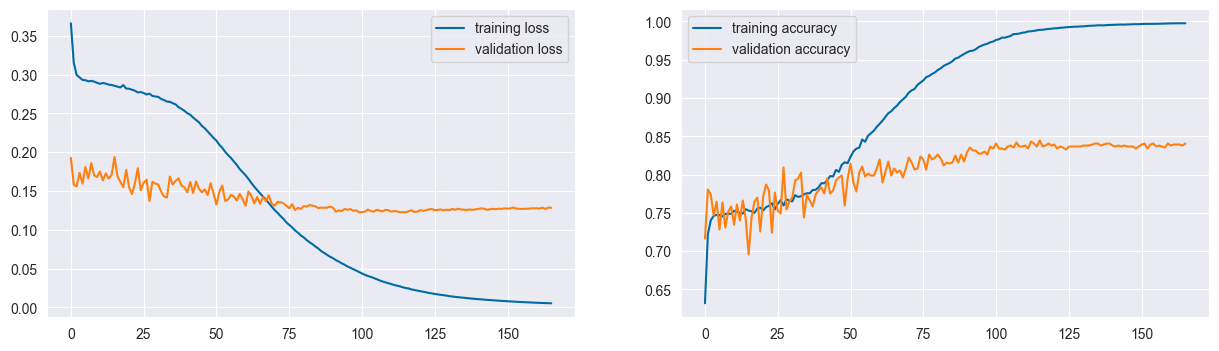

In [20]:
plt.figure(figsize=(15,4))
plt.style.use('tableau-colorblind10')

# Plots of loss curves during training
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

# Plots of accuracy curves during training
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="training accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

plt.show()

In [21]:
# Define model
best_model = CNN2a_model(channels=8, filters=10)

# Load best model weights from h5 file
best_model.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model.keras")

# Compile best model model
best_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import csv

# Read CSV file into a Python list
electrode_names = []

with open(channel_name_file_path, "r") as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        electrode_names.extend(row)  # Add each row to the list (handles single-column CSV)

print(electrode_names)


# remove this channel from the list
electrode_names_to_remove = ['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'Ft7', 'Ft8', 'Tp7', 'Tp8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8']


# Create array has the original index for electrode_names_to_remove in electrode_names
index = []
for i in range(len(electrode_names_to_remove)):
    index.append(electrode_names.index(electrode_names_to_remove[i]))
print(index)

electrode_names = [x for x in electrode_names if x not in electrode_names_to_remove]
print(electrode_names)
    
    
montage = mne.channels.make_standard_montage("standard_1020")

# Create random weights for 10 filters (20 channels)
n_channels = len(electrode_names)
n_filters = 10

# Create a list of weights for all filters
nf = []
for filt in range(10):
    nf.append(abs(np.array(best_model.get_weights()[0])[0, :, filt]))
# remove the channels from the weights 
nf = np.delete(nf, index, axis=1)



# Create an Info object with EEG channel names
info = mne.create_info(ch_names=electrode_names, sfreq=1000, ch_types="eeg")
info.set_montage(montage)

# Plot topomap for each filter
# Set give me array of background color
fig, axes = plt.subplots(2, 5, figsize=(15, 6), facecolor="#000000")  # Set overall background to black
axes = axes.flatten()

for i in range(n_filters):
    ax = axes[i]
    mne.viz.plot_topomap(
        nf[i], info, axes=ax, cmap="Spectral_r", sphere=1.2, show=False  # Adjust `sphere` to scale brain size
    )
    ax.set_title(f"Filter #{i + 1}", color="white")  # Set title color to white for better visibility

plt.tight_layout()
plt.show()


['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz']
[0, 1, 2, 3, 4, 5, 6, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 38, 39, 44, 45, 55, 56, 57, 58, 59]
['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Fp1', 'Fpz', 'Fp2', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'T7', 'T8', 'T9', 'T10', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'O1', 'Oz', 'O2', 'Iz']


IndexError: index 14 is out of bounds for axis 0 with size 8

In [ ]:
# Accuracy over the testing set
predictions = best_model.predict(test_features)
predictions = np.round(predictions)

score = np.array(best_model.evaluate(test_features, test_labels, verbose=0, sample_weight=test_weights))
print("Model performance on test set:\t[ Loss: {}\tAccuracy: {} ]".format(*score.round(4)))
print("\nPredictions: {}\nSolutions:   {}".format(list(map(int, predictions))[:50], list(map(int, test_labels))[:50]))

In [ ]:
# Weighted confusion matrix (noP300: 80%, P300: 20%)
data_train = confusion_matrix(y_true=test_labels, y_pred=predictions, sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data_train / np.full(data_train.shape, len(test_labels))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(test_labels), index = np.unique(test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale = 1.4)
cm = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws = {"size": 16}, vmin=0, vmax=1)
cm.axes.set_title("CNN2a confusion matrix\n", fontsize=20)
plt.show()

In [ ]:
# Model metrics (sens, spec, ppv, npv)
def model_metrics(conf_matrix):
    tn, fp, fn, tp = list(data_norm.flatten())
    sens = round(tp/(tp+fn),4) # Sensitivity
    spec = round(tn/(tn+fp),4) # Specificity
    ppv = round(tp/(tp+fp),4) # Positive Predicted Value
    npv = round(tn/(tn+fn),4) # Negative Predicted Value
    return {"Sensitivity":sens, "Specificity":spec, "PPV":ppv, "NPV":npv}

In [ ]:
# Put model metrics into a table
metrics = model_metrics(data_norm)

# Create figure
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(111)

# Hide graph outlines
for item in [fig, ax]:
    item.patch.set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Table definition
table = ax.table(cellText=[list(metrics.values())], 
                     colLabels=list(metrics.keys()),
                     loc="center",
                     cellLoc="center",
                     colColours=["c"]*4)
table.set_fontsize(16)
table.scale(2,2)

plt.show()